In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/name_mapping_validation_data.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/survival_evaluation.csv
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_flair.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t2.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1ce.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_084/BraTS20_Validation_084_t1.nii
/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_Br

In [ ]:
import os
import numpy as np
import nibabel as nib
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

# Instantiate scaler
scaler = MinMaxScaler()

# Create directories if they don't exist
image_save_dir = 'BraTS2020_TrainingData/input_data_3channels/images/'
mask_save_dir = 'BraTS2020_TrainingData/input_data_3channels/masks/'

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

# File paths
t2_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

# Print the number of files found
print(f"Number of T2 files: {len(t2_list)}")
print(f"Number of T1CE files: {len(t1ce_list)}")
print(f"Number of FLAIR files: {len(flair_list)}")
print(f"Number of Mask files: {len(mask_list)}")

# Set maximum number of images to process
max_images = 295
image_counter = 0

# Iterate over each image (using the t2 list as reference)
for img in range(len(t2_list)):   
    if image_counter >= max_images:
        break

    # Exclude 'BraTS20_Training_355' file
    if 'BraTS20_Training_355' in t2_list[img]:
        print(f"Skipping BraTS20_Training_355 for image index {img}")
        continue
    
    print(f"Now preparing image and masks number: {img}")
    
    # Load and normalize t2, t1ce, flair images
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    # Load and process mask
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values from 4 to 3
    
    # Stack the image modalities together into one array
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to dimensions divisible by 64 (for patching)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Check if at least 1% of the mask has useful labels (not 0)
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0] / counts.sum())) > 0.01:
        print("Saving useful data...")

        # Convert mask to categorical format (one-hot encoding for multi-class segmentation)
        temp_mask = to_categorical(temp_mask, num_classes=4)

        # Save the images and masks
        np.save(os.path.join(image_save_dir, f'image_{img}.npy'), temp_combined_images)
        np.save(os.path.join(mask_save_dir, f'mask_{img}.npy'), temp_mask)
        
        image_counter += 1
    else:
        print("I am useless")

print("Data preparation complete.")

Number of T2 files: 369
Number of T1CE files: 369
Number of FLAIR files: 369
Number of Mask files: 368
Now preparing image and masks number: 0
Saving useful data...
Now preparing image and masks number: 1
Saving useful data...
Now preparing image and masks number: 2
Saving useful data...
Now preparing image and masks number: 3
Saving useful data...
Now preparing image and masks number: 4
I am useless
Now preparing image and masks number: 5
Saving useful data...
Now preparing image and masks number: 6
Saving useful data...
Now preparing image and masks number: 7
Saving useful data...
Now preparing image and masks number: 8
Saving useful data...
Now preparing image and masks number: 9
Saving useful data...
Now preparing image and masks number: 10
Saving useful data...
Now preparing image and masks number: 11
Saving useful data...
Now preparing image and masks number: 12
Saving useful data...
Now preparing image and masks number: 13
Saving useful data...
Now preparing image and masks numb

In [4]:
import os
import numpy as np
import nibabel as nib
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

# Instantiate scaler
scaler = MinMaxScaler()

# Create directories if they don't exist
image_save_dir = '/kaggle/working/val/images/'
mask_save_dir = '/kaggle/working/val/masks/'

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(mask_save_dir, exist_ok=True)

# File paths
t2_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

# Print the number of files found
print(f"Number of T2 files: {len(t2_list)}")
print(f"Number of T1CE files: {len(t1ce_list)}")
print(f"Number of FLAIR files: {len(flair_list)}")
print(f"Number of Mask files: {len(mask_list)}")

# Set maximum number of images to process (adjusted for the range 100 to 140)
max_images = 35
image_counter = 0

# Iterate over a specific range of images (from 100 to 140)
for img in range(0, 35):
    if image_counter >= max_images:
        break

    # Exclude 'BraTS20_Training_355' file
    if 'BraTS20_Training_355' in t2_list[img]:
        print(f"Skipping BraTS20_Training_355 for image index {img}")
        continue
    
    print(f"Now preparing image and masks number: {img}")
    
    # Load and normalize t2, t1ce, flair images
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    # Load and process mask
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3  # Reassign mask values from 4 to 3
    
    # Stack the image modalities together into one array
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    # Crop to dimensions divisible by 64 (for patching)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Check if at least 1% of the mask has useful labels (not 0)
    val, counts = np.unique(temp_mask, return_counts=True)
    if (1 - (counts[0] / counts.sum())) > 0.01:
        print("Saving useful data...")

        # Convert mask to categorical format (one-hot encoding for multi-class segmentation)
        temp_mask = to_categorical(temp_mask, num_classes=4)

        # Save the images and masks
        np.save(os.path.join(image_save_dir, f'image_{img}.npy'), temp_combined_images)
        np.save(os.path.join(mask_save_dir, f'mask_{img}.npy'), temp_mask)
        
        image_counter += 1
    else:
        print("I am useless")

print("Data preparation complete.")


Number of T2 files: 369
Number of T1CE files: 369
Number of FLAIR files: 369
Number of Mask files: 368
Now preparing image and masks number: 0
Saving useful data...
Now preparing image and masks number: 1
Saving useful data...
Now preparing image and masks number: 2
Saving useful data...
Now preparing image and masks number: 3
Saving useful data...
Now preparing image and masks number: 4
I am useless
Now preparing image and masks number: 5
Saving useful data...
Now preparing image and masks number: 6
Saving useful data...
Now preparing image and masks number: 7
Saving useful data...
Now preparing image and masks number: 8
Saving useful data...
Now preparing image and masks number: 9
Saving useful data...
Now preparing image and masks number: 10
Saving useful data...
Now preparing image and masks number: 11
Saving useful data...
Now preparing image and masks number: 12
Saving useful data...
Now preparing image and masks number: 13
Saving useful data...
Now preparing image and masks numb

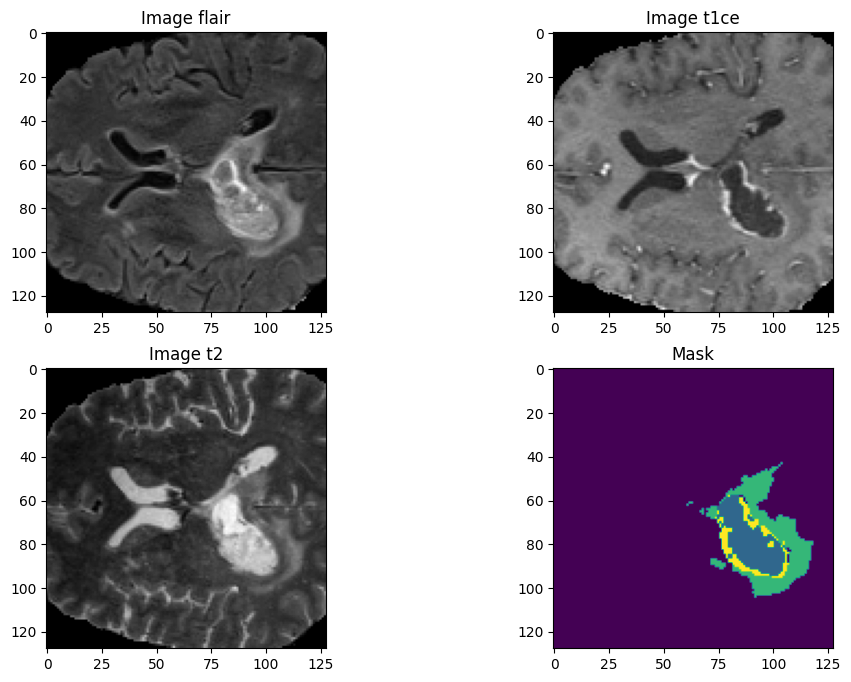

In [5]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random



####################################################
train_img_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
#Define the image generators for training and validation

train_img_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"

val_img_dir = "/kaggle/working/val/images/"
val_mask_dir = "/kaggle/working/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [7]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [8]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [9]:
from matplotlib import pyplot as plt
import random

train_img_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

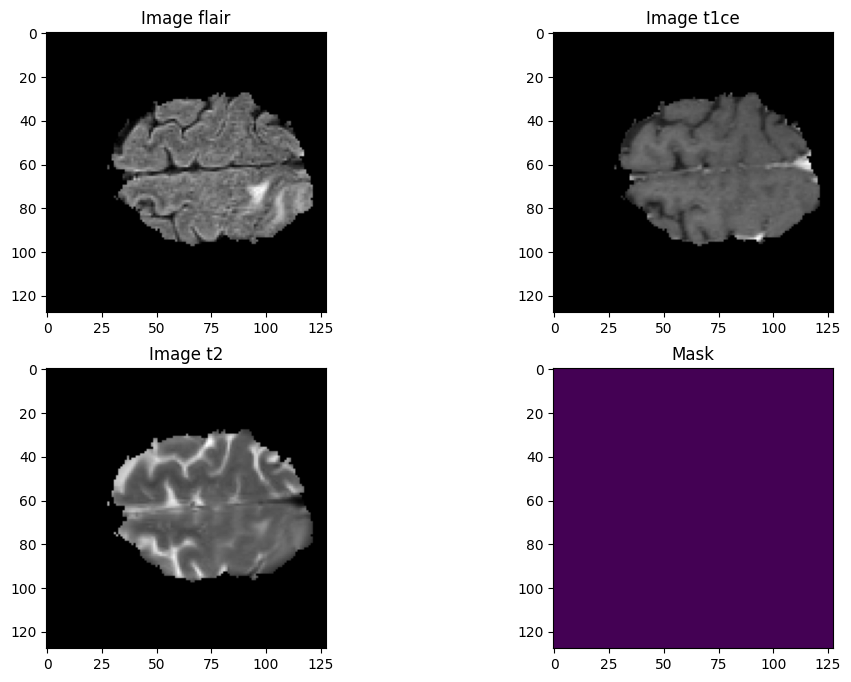

In [10]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [39]:
import shutil
import os

# Specify the path to the directory you want to delete
directory_path = '/kaggle/working/BraTS2020_TrainingData/'

# Check if the directory exists
if os.path.isdir(directory_path):
    # Delete the directory and its contents
    shutil.rmtree(directory_path)
    print(f"The directory {directory_path} has been deleted.")
else:
    print(f"The directory {directory_path} does not exist.")


The directory /kaggle/working/BraTS2020_TrainingData/ has been deleted.


In [40]:
import os
import numpy as np
import nibabel as nib
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

# Instantiate scaler
scaler = MinMaxScaler()

# Create directories if they don't exist
image_save_dir2 = 'BraTS2020_TrainingData/input_data_3channels/images/'
mask_save_dir2 = 'BraTS2020_TrainingData/input_data_3channels/masks/'

os.makedirs(image_save_dir2, exist_ok=True)
os.makedirs(mask_save_dir2, exist_ok=True)

# File paths
t2_list2 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list2 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list2 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list2 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

# Print the number of files found
print(f"Number of T2 files: {len(t2_list2)}")
print(f"Number of T1CE files: {len(t1ce_list2)}")
print(f"Number of FLAIR files: {len(flair_list2)}")
print(f"Number of Mask files: {len(mask_list2)}")

# Get the last 100 files
num_files = 100
t2_list2 = t2_list2[-num_files:]
t1ce_list2 = t1ce_list2[-num_files:]
flair_list2 = flair_list2[-num_files:]
mask_list2 = mask_list2[-num_files:]

# Print the number of files to process
print(f"Processing the last {num_files} files.")

# Set maximum number of images to process
max_images = num_files
image_counter2 = 0

# Iterate over each image (using the t2 list as reference)
for img2 in range(len(t2_list2)):   
    if image_counter2 >= max_images:
        break

    # Exclude 'BraTS20_Training_355' file
    if 'BraTS20_Training_355' in t2_list2[img2]:
        print(f"Skipping BraTS20_Training_355 for image index {img2}")
        continue
    
    print(f"Now preparing image and masks number: {img2}")
    
    # Load and normalize t2, t1ce, flair images
    temp_image_t2_2 = nib.load(t2_list2[img2]).get_fdata()
    temp_image_t2_2 = scaler.fit_transform(temp_image_t2_2.reshape(-1, temp_image_t2_2.shape[-1])).reshape(temp_image_t2_2.shape)

    temp_image_t1ce_2 = nib.load(t1ce_list2[img2]).get_fdata()
    temp_image_t1ce_2 = scaler.fit_transform(temp_image_t1ce_2.reshape(-1, temp_image_t1ce_2.shape[-1])).reshape(temp_image_t1ce_2.shape)

    temp_image_flair_2 = nib.load(flair_list2[img2]).get_fdata()
    temp_image_flair_2 = scaler.fit_transform(temp_image_flair_2.reshape(-1, temp_image_flair_2.shape[-1])).reshape(temp_image_flair_2.shape)

    # Load and process mask
    temp_mask_2 = nib.load(mask_list2[img2]).get_fdata().astype(np.uint8)
    temp_mask_2[temp_mask_2 == 4] = 3  # Reassign mask values from 4 to 3
    
    # Stack the image modalities together into one array
    temp_combined_images_2 = np.stack([temp_image_flair_2, temp_image_t1ce_2, temp_image_t2_2], axis=3)

    # Crop to dimensions divisible by 64 (for patching)
    temp_combined_images_2 = temp_combined_images_2[56:184, 56:184, 13:141]
    temp_mask_2 = temp_mask_2[56:184, 56:184, 13:141]

    # Check if at least 1% of the mask has useful labels (not 0)
    val_2, counts_2 = np.unique(temp_mask_2, return_counts=True)
    if (1 - (counts_2[0] / counts_2.sum())) > 0.01:
        print("Saving useful data...")

        # Convert mask to categorical format (one-hot encoding for multi-class segmentation)
        temp_mask_2 = to_categorical(temp_mask_2, num_classes=4)

        # Save the images and masks
        np.save(os.path.join(image_save_dir2, f'image_{img2}.npy'), temp_combined_images_2)
        np.save(os.path.join(mask_save_dir2, f'mask_{img2}.npy'), temp_mask_2)
        
        image_counter2 += 1
    else:
        print("I am useless")

print("Data preparation complete.")


Number of T2 files: 369
Number of T1CE files: 369
Number of FLAIR files: 369
Number of Mask files: 368
Processing the last 100 files.
Now preparing image and masks number: 0
Saving useful data...
Now preparing image and masks number: 1
Saving useful data...
Now preparing image and masks number: 2
Saving useful data...
Now preparing image and masks number: 3
Saving useful data...
Now preparing image and masks number: 4
Saving useful data...
Now preparing image and masks number: 5
Saving useful data...
Now preparing image and masks number: 6
Saving useful data...
Now preparing image and masks number: 7
Saving useful data...
Now preparing image and masks number: 8
I am useless
Now preparing image and masks number: 9
Saving useful data...
Now preparing image and masks number: 10
Saving useful data...
Now preparing image and masks number: 11
Saving useful data...
Now preparing image and masks number: 12
Saving useful data...
Now preparing image and masks number: 13
Saving useful data...
Now

In [42]:
################
samp_imgdir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
samp_maskdir= "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"

samp_imglist=os.listdir(samp_imgdir)
samp_masklist = os.listdir(samp_maskdir)

In [44]:
batch_size = 2

train_img_datagen2 = imageLoader(samp_imgdir, samp_imglist, 
                                samp_maskdir, samp_masklist, batch_size)

In [27]:
from itertools import cycle

def combined_generator(gen1, gen2):
    for batch1, batch2 in zip(cycle(gen1), cycle(gen2)):
        yield batch1
        yield batch2

# Create a combined generator
combined_train_datagen = combined_generator(train_img_datagen, train_img_datagen2)

NameError: name 'train_img_datagen' is not defined

In [48]:
##########################

In [26]:
import tensorflow as tf
import numpy as np

# Define Dice Loss with Class Weights
def dice_loss(y_true, y_pred, smooth=1e-6, class_weights=None):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if class_weights is not None:
        weights = tf.reduce_sum(class_weights * y_true, axis=-1)
        dice = tf.reduce_sum(weights * dice) / tf.reduce_sum(weights)
    
    return 1. - dice

# Define Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        alpha_t = y_true * alpha + (tf.keras.backend.ones_like(y_true) - y_true) * (1 - alpha)
        p_t = y_true * y_pred + (tf.keras.backend.ones_like(y_true) - y_true) * (1 - y_pred)
        fl = -alpha_t * tf.keras.backend.pow((tf.keras.backend.ones_like(y_true) - p_t), gamma) * tf.keras.backend.log(p_t)
        return tf.keras.backend.mean(fl)
    
    return focal_loss_fixed

# Combined Loss
def combined_loss(y_true, y_pred):
    wt0, wt1, wt2, wt3 = 0.25, 0.25, 0.25, 0.25
    class_weights = np.array([wt0, wt1, wt2, wt3])
    
    dice = dice_loss(y_true, y_pred, class_weights=class_weights)
    focal = focal_loss()(y_true, y_pred)
    
    return dice + focal

# Define IoU Metric
def iou_score(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

# Example Model Definition
def create_model(input_shape=(256, 256, 256, 1), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling3D((2, 2, 2))(x)
    x = tf.keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling3D((2, 2, 2))(x)
    x = tf.keras.layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model

# Define Learning Rate and Optimizer
LR = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Create and Compile the Model
model = create_model(input_shape=(256, 256, 256, 1), num_classes=4)
model.compile(optimizer=optimizer, loss=combined_loss, metrics=[iou_score])

# Print Model Summary
model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 256, 256, 256,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_445 (Conv3D)             │ (None, 256, 256, 256,  │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_87 (MaxPooling3D) │ (None, 128, 128, 128,  │             0 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_446 (Conv3D)             │ (None, 128, 128, 128,  │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_88 (MaxPooling3D) │ (None, 64, 64, 64, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_447 (Conv3D)             │ (None, 64, 64, 64, 4)  │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,516 (220.77 KB)

 Trainable params: 56,516 (220.77 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

#Test if everything is working ok. 
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d_3[0][0]    │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 64, 64,    │          0 │ conv3d_4[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d_2[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_5[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 32, 32,    │          0 │ conv3d_6[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_3[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_7[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 16, 16,    │          0 │ conv3d_8[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_4[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_9[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_10 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 8, 8, 8,   │          0 │ conv3d_10[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [53]:
train_img_final =train_img_list+samp_imglist

In [13]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
metrics = ['accuracy']


# Define the loss function
total_loss = CategoricalCrossentropy()

# Compile the model

# Define the optimizer
optim = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)


print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('/kaggle/working/BraTS2020_TrainingData/brats_3d.hdf5')

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_2[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_22[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 64, 64,    │          0 │ conv3d_23[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_6[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_24[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 32, 32,    │          0 │ conv3d_25[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_7[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_26[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_27 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_8     │ (None, 16, 16,    │          0 │ conv3d_27[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_8[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_28[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_9     │ (None, 8, 8, 8,   │          0 │ conv3d_29[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_2[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_22[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 64, 64,    │          0 │ conv3d_23[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_6[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_24[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 32, 32,    │          0 │ conv3d_25[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_7[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_26[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_27 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_8     │ (None, 16, 16,    │          0 │ conv3d_27[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_8[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_28[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_9     │ (None, 8, 8, 8,   │          0 │ conv3d_29[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1396s 82s/step - accuracy: 0.8523 - loss: 25713299456.0000 - val_accuracy: 0.9595 - val_loss: 0.9429
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1443s 85s/step - accuracy: 0.9561 - loss: 0.8526 - val_accuracy: 0.9593 - val_loss: 0.6132
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1430s 87s/step - accuracy: 0.9588 - loss: 0.5571 - val_accuracy: 0.9593 - val_loss: 0.4279
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1415s 83s/step - accuracy: 0.9588 - loss: 0.4004 - val_accuracy: 0.9599 - val_loss: 0.3320
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1431s 85s/step - accuracy: 0.9602 - loss: 0.3166 - val_accuracy: 0.9623 - val_loss: 0.2759


In [14]:
# Continue training for another epoch
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,
    epochs=7,  # Change to the new total number of epochs
    initial_epoch=5,  # Start from the last completed epoch
    verbose=1,
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
)


Epoch 6/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 1433s 85s/step - accuracy: 0.9602 - loss: 0.2735 - val_accuracy: 0.9623 - val_loss: 0.2476
Epoch 7/7
17/17 ━━━━━━━━━━━━━━━━━━━━ 1414s 84s/step - accuracy: 0.9602 - loss: 0.2486 - val_accuracy: 0.9591 - val_loss: 0.2407


In [15]:
import os
import numpy as np
import nibabel as nib
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical

# Instantiate scaler
scaler3 = MinMaxScaler()

# Create directories if they don't exist
image_save_dir3 = '/kaggle/working/test/images/'
mask_save_dir3 = '/kaggle/working/test/masks/'

os.makedirs(image_save_dir3, exist_ok=True)
os.makedirs(mask_save_dir3, exist_ok=True)

# File paths
t2_list3 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list3 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list3 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list3 = sorted(glob.glob('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

# Print the number of files found
print(f"Number of T2 files: {len(t2_list3)}")
print(f"Number of T1CE files: {len(t1ce_list3)}")
print(f"Number of FLAIR files: {len(flair_list3)}")
print(f"Number of Mask files: {len(mask_list3)}")

# Get the files from index 100 to 140
start_index3 = 100
end_index3 = 140

t2_list3 = t2_list3[start_index3:end_index3]
t1ce_list3 = t1ce_list3[start_index3:end_index3]
flair_list3 = flair_list3[start_index3:end_index3]
mask_list3 = mask_list3[start_index3:end_index3]

# Print the number of files to process
num_files3 = len(t2_list3)
print(f"Processing files from index {start_index3} to {end_index3 - 1}.")

# Set maximum number of images to process
max_images3 = num_files3
image_counter3 = 0

# Iterate over each image (using the t2 list as reference)
for img3 in range(len(t2_list3)):   
    if image_counter3 >= max_images3:
        break

    # Exclude 'BraTS20_Training_355' file
    if 'BraTS20_Training_355' in t2_list3[img3]:
        print(f"Skipping BraTS20_Training_355 for image index {img3}")
        continue
    
    print(f"Now preparing image and masks number: {img3}")
    
    # Load and normalize t2, t1ce, flair images
    temp_image_t2_3 = nib.load(t2_list3[img3]).get_fdata()
    temp_image_t2_3 = scaler3.fit_transform(temp_image_t2_3.reshape(-1, temp_image_t2_3.shape[-1])).reshape(temp_image_t2_3.shape)

    temp_image_t1ce_3 = nib.load(t1ce_list3[img3]).get_fdata()
    temp_image_t1ce_3 = scaler3.fit_transform(temp_image_t1ce_3.reshape(-1, temp_image_t1ce_3.shape[-1])).reshape(temp_image_t1ce_3.shape)

    temp_image_flair_3 = nib.load(flair_list3[img3]).get_fdata()
    temp_image_flair_3 = scaler3.fit_transform(temp_image_flair_3.reshape(-1, temp_image_flair_3.shape[-1])).reshape(temp_image_flair_3.shape)

    # Load and process mask
    temp_mask_3 = nib.load(mask_list3[img3]).get_fdata().astype(np.uint8)
    temp_mask_3[temp_mask_3 == 4] = 3  # Reassign mask values from 4 to 3
    
    # Stack the image modalities together into one array
    temp_combined_images_3 = np.stack([temp_image_flair_3, temp_image_t1ce_3, temp_image_t2_3], axis=3)

    # Crop to dimensions divisible by 64 (for patching)
    temp_combined_images_3 = temp_combined_images_3[56:184, 56:184, 13:141]
    temp_mask_3 = temp_mask_3[56:184, 56:184, 13:141]

    # Check if at least 1% of the mask has useful labels (not 0)
    val_3, counts_3 = np.unique(temp_mask_3, return_counts=True)
    if (1 - (counts_3[0] / counts_3.sum())) > 0.01:
        print("Saving useful data...")

        # Convert mask to categorical format (one-hot encoding for multi-class segmentation)
        temp_mask_3 = to_categorical(temp_mask_3, num_classes=4)

        # Save the images and masks
        np.save(os.path.join(image_save_dir3, f'image_{img3}.npy'), temp_combined_images_3)
        np.save(os.path.join(mask_save_dir3, f'mask_{img3}.npy'), temp_mask_3)
        
        image_counter3 += 1
    else:
        print("I am useless")

print("Data preparation complete.")


Number of T2 files: 369
Number of T1CE files: 369
Number of FLAIR files: 369
Number of Mask files: 368
Processing files from index 100 to 139.
Now preparing image and masks number: 0
Saving useful data...
Now preparing image and masks number: 1
Saving useful data...
Now preparing image and masks number: 2
Saving useful data...
Now preparing image and masks number: 3
Saving useful data...
Now preparing image and masks number: 4
Saving useful data...
Now preparing image and masks number: 5
Saving useful data...
Now preparing image and masks number: 6
Saving useful data...
Now preparing image and masks number: 7
I am useless
Now preparing image and masks number: 8
Saving useful data...
Now preparing image and masks number: 9
I am useless
Now preparing image and masks number: 10
Saving useful data...
Now preparing image and masks number: 11
Saving useful data...
Now preparing image and masks number: 12
Saving useful data...
Now preparing image and masks number: 13
Saving useful data...
Now

In [10]:
from matplotlib import pyplot as plt
import random

test_img_dir = "/kaggle/working/test/images/"
test_mask_dir = "/kaggle/working/test/masks/"
test_img_list=os.listdir(test_img_dir)
test_mask_list = os.listdir(test_mask_dir)

batch_size = 2

test_img_datagen = imageLoader(test_img_dir, test_img_list, 
                                test_mask_dir, test_mask_list, batch_size)

In [20]:
# Load the model
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/working/BraTS2020_TrainingData/brats_3d.hdf5')

# Define the steps per epoch for the test data
test_steps_per_epoch = len(test_img_list) // batch_size

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_img_datagen, 
                                          steps=test_steps_per_epoch, 
                                          verbose=1)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


18/18 ━━━━━━━━━━━━━━━━━━━━ 214s 12s/step - accuracy: 0.9469 - loss: 0.3178
Test Accuracy: 95.36%


In [ ]:
################ model 222

In [2]:
def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [3]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)


In [4]:

train_img_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"

val_img_dir = "/kaggle/working/val/images/"
val_mask_dir = "/kaggle/working/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [5]:
from matplotlib import pyplot as plt
import random
import os  # Make sure to import os

val_img_dir = "/kaggle/working/val/images/"
val_mask_dir = "/kaggle/working/val/masks/"
val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

batch_size = 2

val_train_datagen3 = imageLoader(val_img_dir, val_img_list, 
                                  val_mask_dir,val_mask_list, batch_size)

In [6]:
from matplotlib import pyplot as plt
import random
import os  # Make sure to import os

train_img_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/images/"
train_mask_dir = "/kaggle/working/BraTS2020_TrainingData/input_data_3channels/masks/"
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

img_train_datagen3 = imageLoader(train_img_dir, train_img_list, 
                                  train_mask_dir, train_mask_list, batch_size)


In [7]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout

kernel_initializer = 'he_uniform'  # Try others if you want

def simple_unet_with_fpn(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    # Expansive path with FPN
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

# Test if everything is working okay.
model = simple_unet_with_fpn(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 128, 128,  │      1,312 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv3d[0][0]      │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 128, 128,  │      6,928 │ dropout[0][0]     │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 64, 64,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 64, 64,    │     13,856 │ max_pooling3d[0]… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv3d_2[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 64, 64,    │     27,680 │ dropout_1[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 32, 32,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 32, 32,    │     55,360 │ max_pooling3d_1[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv3d_4[0][0]    │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    110,656 │ dropout_2[0][0]   │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 16, 16,    │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 16, 16,    │    221,312 │ max_pooling3d_2[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv3d_6[0][0]    │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 16, 16,    │    442,496 │ dropout_3[0][0]   │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_3     │ (None, 8, 8, 8,   │          0 │ conv3d_7[0][0]  

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)


In [8]:
# Calculate steps per epoch
steps_per_epoch = len(train_img_list) // batch_size
val_steps_per_epoch = len(val_img_list) // batch_size

# Define the model
model = simple_unet_with_fpn(IMG_HEIGHT=128, 
                              IMG_WIDTH=128, 
                              IMG_DEPTH=128, 
                              IMG_CHANNELS=3, 
                              num_classes=4)

# Import necessary modules
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define the loss function and metrics
total_loss = CategoricalCrossentropy()
metrics = ['accuracy']

# Define the optimizer
optim = Adam(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

# Print model summary
print(model.summary())
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

# Train the model
history = model.fit(img_train_datagen3,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,
                    verbose=1,
                    validation_data=val_train_datagen3,
                    validation_steps=val_steps_per_epoch)

# Save the trained model
model.save('/kaggle/working/BraTS2020_TrainingData/Unet_with_FPN.hdf5')


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 128, 128,  │      1,312 │ input_layer_1[0]… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128, 128,  │          0 │ conv3d_19[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_20 (Conv3D)  │ (None, 128, 128,  │      6,928 │ dropout_9[0][0]   │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 64, 64,    │          0 │ conv3d_20[0][0]   │
│ (MaxPooling3D)      │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_21 (Conv3D)  │ (None, 64, 64,    │     13,856 │ max_pooling3d_4[… │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64, 64,    │          0 │ conv3d_21[0][0]   │
│ (Dropout)           │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_22 (Conv3D)  │ (None, 64, 64,    │     27,680 │ dropout_10[0][0]  │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 32, 32,    │          0 │ conv3d_22[0][0]   │
│ (MaxPooling3D)      │ 32, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_23 (Conv3D)  │ (None, 32, 32,    │     55,360 │ max_pooling3d_5[… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 32, 32,    │          0 │ conv3d_23[0][0]   │
│ (Dropout)           │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 32, 32,    │    110,656 │ dropout_11[0][0]  │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 16, 16,    │          0 │ conv3d_24[0][0]   │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 16, 16,    │    221,312 │ max_pooling3d_6[… │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 16, 16,    │          0 │ conv3d_25[0][0]   │
│ (Dropout)           │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 16, 16,    │    442,496 │ dropout_12[0][0]  │
│                     │ 16, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 8, 8, 8,   │          0 │ conv3d_26[0][0] 

 Total params: 5,645,828 (21.54 MB)

 Trainable params: 5,645,828 (21.54 MB)

 Non-trainable params: 0 (0.00 B)

None
Input shape: (None, 128, 128, 128, 3)
Output shape: (None, 128, 128, 128, 4)
Epoch 1/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1463s 86s/step - accuracy: 0.8190 - loss: 459879904.0000 - val_accuracy: 0.9595 - val_loss: 0.9625
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1416s 86s/step - accuracy: 0.9588 - loss: 0.8700 - val_accuracy: 0.9593 - val_loss: 0.6435
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1425s 84s/step - accuracy: 0.9588 - loss: 0.5884 - val_accuracy: 0.9593 - val_loss: 0.4550
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1429s 83s/step - accuracy: 0.9602 - loss: 0.4236 - val_accuracy: 0.9599 - val_loss: 0.3526
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1412s 83s/step - accuracy: 0.9602 - loss: 0.3360 - val_accuracy: 0.9623 - val_loss: 0.2917


In [11]:
# Load the model
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/kaggle/working/BraTS2020_TrainingData/Unet_with_FPN.hdf5')

# Define the steps per epoch for the test data
test_steps_per_epoch = len(test_img_list) // batch_size

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_img_datagen, 
                                          steps=test_steps_per_epoch, 
                                          verbose=1)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


18/18 ━━━━━━━━━━━━━━━━━━━━ 207s 11s/step - accuracy: 0.9469 - loss: 0.3321
Test Accuracy: 95.36%
